# Manejo de Datos en Biología Computacional. Herramientas de Estadística: Trabajo Final.
## Fernando Leonel Da Rosa Jurao

## Introducción

 *   Un poco de contexto.

        Actualmente, estoy realizando el doctorado en el Instituto LEICI de la Facultad de Ingeniería de la UNLP. En particular, estoy involucrado en un proyecto de desarrollo de un dispositivo médico conocido como Páncreas Artificial (PA). El PA tiene como objetivo regular la glucemia en personas que padecen Diabetes Mellitus Tipo 1 (DMT1) y está compuesto por tres elementos principales: un monitor continuo de glucosa (CGM), una bomba de insulina y un algoritmo de control. Éste último recibe las medidas del CGM y calcula una dosis de insulina que luego es entregada por la bomba. Mi trabajo se centra, principalmente, en el desarrollo de estos algorimos utilizando distintas estrategias de control automático. Una parte fundamental en el desarrollo de controladores para PA, es la validación de las estrategias utilizadas. Gracias al avance de los distintos grupos de investigación alrededor del mundo, en la actualidad se dispone de simuladores que representan la dinámica de la glucemia en personas con DMT1. Además, existen modelos aprobados por la FDA (Food and Drug Administration) como reemplazo de los ensayos preclínicos en animales. Ésto nos permite validar y evaluar distintos tipos de técnicas de control únicamente realizando simulaciones en una computadora (validación in silico).



*    El origen de los datos utilizados

       En el grupo de trabajo se desarrolló un algoritmo de PA llamado Automatic Regulation of Glucose (ARG), el cual fue validado experimentalmente en los primeros ensayos clínicos de Latinoamérica. Este algoritmo utiliza un controlador llamado LQG (Linear Quadratic Gaussian), que a pesar de haber obtenido resultados satisfactorios en dichos ensayos, también resulta compleja su implementación y su funcionamiento no es simple de entender para el personal médico que participa en las pruebas. Por esta razón, se exploró la alternativa de utilizar un controlador más sencillo de implementar y comprender llamado PD (Proportional Derivative). Para contrastar el funcionamiento del nuevo controlador (PD) con el original (LQG), se utizó un simulador en donde se creó un escenario virtual. Los datos que se presentan en este trabajo son los resultados de la evolución temporal de glucemia obtenida en dichas simulaciones con cada estrategia. 

*    Escenario de simulacion

       En el escenario planteado se utilizó una población de 10 adultos, cada uno con caracteristicas únicas. Se les dió una comida de 70 gramos de carbohidratos exactamente a la misma hora (1 hora despues del inicio de la simulacion). Todos los pacientes se encuentran bajo tratamiento, de manera que la condición inicial de simulación es la misma para toda la población. Esta prueba se repitió dos veces para cada paciente virtual, es decir, una vez con cada estrategia (LQG y PD) en un periodo de observación de 8 horas por simulación.

*    Objetivo

       El objetivo de este trabajo es extraer valores estrategicos del dataset que permitan observar si exite una diferencia en la glucemia al utilizar la nueva estrategia en lugar de la original.


In [2]:
# Se importan las bibliotecas utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from statsmodels.stats.power import TTestIndPower
from sklearn.linear_model import LinearRegression


La tabla de datos contiene, en cada columna, la evolucion de la glucemia en funcion del tiempo de los pacientes, donde las primeras 10 columnas corresponden al tratamiento del LQG y las últimas 10 al PD. En la siguiente celda de código se importa la tabla y se muestran las primeras filas para ilustrar como están ordenados los datos.

In [3]:
# Importación de los datos
# Nombre del archivo
file_name = 'tabla_glucosa_70gCHO.csv'
# Lectura del archivo
df = pd.read_csv(file_name)
df.head()

,lqg_adulto_1,lqg_adulto_2,lqg_adulto_3,lqg_adulto_4,lqg_adulto_5,lqg_adulto_6,lqg_adulto_7,lqg_adulto_8,lqg_adulto_9,lqg_adulto_10,pd_adulto_1,pd_adulto_2,pd_adulto_3,pd_adulto_4,pd_adulto_5,pd_adulto_6,pd_adulto_7,pd_adulto_8,pd_adulto_9,pd_adulto_10
0,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
1,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
2,109.999188,109.998190,109.999775,109.999875,109.999841,109.999980,109.999848,109.997535,109.999986,109.999985,109.999188,109.998190,109.999775,109.999875,109.999841,109.999980,109.999848,109.997535,109.999986,109.999985
3,109.997730,109.994985,109.999361,109.999641,109.999556,109.999944,109.999590,109.993323,109.999960,109.999958,109.997730,109.994985,109.999361,109.999641,109.999556,109.999944,109.999590,109.993323,109.999960,109.999958
4,109.995762,109.990710,109.998788,109.999309,109.999168,109.999895,109.999258,109.987874,109.999926,109.999921,109.995762,109.990710,109.998788,109.999309,109.999168,109.999895,109.999258,109.987874,109.999926,109.999921


Como se mencionó en la introducción, los datos pertenecen a pacientes virtuales los cuales estan ordenados por columnas y, además, se utilizó dos estrategias distintas para cada uno. A continuación, se separan los datos según el tratamiento utilizado y luego se grafican en funcion del tiempo el valor medio y su desviación estándar para ilustrar el comportamiento de los datos.

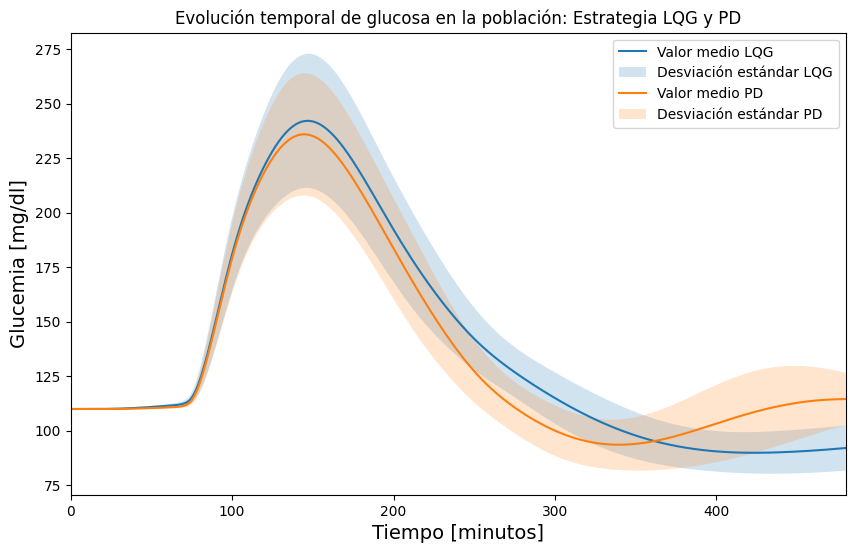

In [4]:
%matplotlib inline
#%matplotlib qt

# Separacion de datos para cada estrategia
glcuemia_lqg = df.iloc[:,0:10]
glcuemia_pd  = df.iloc[:,10:20]
t   = np.arange(0, len(glcuemia_lqg), 1)

# Cálculo del valor medio y desviación estándar de cada una
vm_lqg  = np.mean(glcuemia_lqg,axis=1)
std_lqg = np.std(glcuemia_lqg,axis=1)
vm_pd   = np.mean(glcuemia_pd,axis=1)
std_pd  = np.std(glcuemia_pd,axis=1)

# Presentación de gráficos 
plt.figure(figsize=(10,6))
plt.plot(t,vm_lqg,label='Valor medio LQG')
plt.fill_between(t,vm_lqg-std_lqg,vm_lqg+std_lqg, alpha=0.2, label='Desviación estándar LQG')
plt.plot(t,vm_pd,label='Valor medio PD')
plt.fill_between(t,vm_pd-std_pd,vm_pd+std_pd, alpha=0.2, label='Desviación estándar PD')
plt.xlim(t[0], t[len(glcuemia_lqg)-1])
plt.ylabel("Glucemia [mg/dl]",fontsize=14)
plt.xlabel("Tiempo [minutos]",fontsize=14)
plt.legend()
plt.title('Evolución temporal de glucosa en la población: Estrategia LQG y PD')
plt.show()

En la figura anterior se observa el valor medio y la desviación estándar de glucemia obtenida con cada estrategia, para el análisis de comparacion se extraen los siguientes valores de interes: 
*   Valor de glucemia antes de la comida (en ayuno)
*   Pico máximo de glucemia en cada paciente debido a la comida.

Estos valores son importantes para observar como se compensa el efecto que tiene la comida en la glucemia al utilizar cada una de las estrategias. 

In [5]:
# Extracción de los puntos de interes para el analisis

# Pico máximo de glucemia de cada paciente con ambas estrategias
lqg_max = glcuemia_lqg.max()
pd_max  = glcuemia_pd.max()
#print(lqg_max,"\n",pd_max)

# Valor de glucemia en ayuno
lqg_ayuno = glcuemia_lqg.iloc[20]
pd_ayuno  = glcuemia_pd.iloc[20]

# Calculo de las medidas caracteristicas de centralización y dispersión de los datos de interes

# Promedio 
mean_lqg_max   = np.mean(lqg_max)
mean_pd_max    = np.mean(pd_max)
mean_lqg_ayuno = np.mean(lqg_ayuno)
mean_pd_ayuno  = np.mean(pd_ayuno)

# Desviación estándar 
std_lqg_max   = np.std(lqg_max)
std_pd_max    = np.std(pd_max)
std_lqg_ayuno = np.std(lqg_ayuno)
std_pd_ayuno  = np.std(pd_ayuno)

# Intervalo de confianza 
# Varianza poblacional desconocida (t Student) 
# Confianza = 1-alpha
# Significancia = alpha
# Numero de muestras

n    = 10
conf = 0.95
in_lqg_max   = ss.t.interval(conf, 9, loc=mean_lqg_max, scale=std_lqg_max)
in_lqg_ayuno = ss.t.interval(conf, 9, loc=mean_lqg_ayuno, scale=std_lqg_ayuno)
in_pd_max    = ss.t.interval(conf, 9, loc=mean_pd_max, scale=std_pd_max)
in_pd_ayuno  = ss.t.interval(conf, 9, loc=mean_pd_ayuno, scale=std_pd_ayuno)

print("Promedio de los valores máximos de glucemia con el LQG: {:.2f} [mg/dl].".format(mean_lqg_max),"Desviacion estándar: {:.2f} [mg/dl]".format(std_lqg_max))
print("Promedio de los valores máximos de glucemia con el PD: {:.2f} [mg/dl].".format(mean_pd_max),"Desviacion estándar: {:.2f} [mg/dl]".format(std_pd_max))
print("Promedio de los valores glucemia en ayuno con el LQG: {:.2f} [mg/dl].".format(mean_lqg_ayuno),"Desviacion estándar: {:.2f} [mg/dl]".format(std_lqg_ayuno))
print("Promedio de los valores glucemia en ayuno con el PD: {:.2f} [mg/dl].".format(mean_pd_ayuno),"Desviacion estándar: {:.2f} [mg/dl]".format(std_pd_ayuno))
print(in_lqg_max)
print(in_pd_max)
print(in_lqg_ayuno)
print(in_pd_ayuno)

Promedio de los valores máximos de glucemia con el LQG: 243.44 [mg/dl]. Desviacion estándar: 29.92 [mg/dl]
Promedio de los valores máximos de glucemia con el PD: 237.45 [mg/dl]. Desviacion estándar: 27.15 [mg/dl]
Promedio de los valores glucemia en ayuno con el LQG: 110.01 [mg/dl]. Desviacion estándar: 0.06 [mg/dl]
Promedio de los valores glucemia en ayuno con el PD: 109.98 [mg/dl]. Desviacion estándar: 0.05 [mg/dl]
(175.75155143940407, 311.13233659014753)
(176.04219278606513, 298.8663918949573)
(109.87996397414453, 110.14201807438108)
(109.86335421426406, 110.08697297593235)


In [22]:
# Tamaño muestral

# Parámetros de la prueba
datos_std_max   = np.std(df.max())
datos_std_ayuno = np.std(df.iloc[20])
#abs(mean_lqg_max - mean_pd_max)
effect_size_mean  = 50/ datos_std_max
effect_size_ayuno = 0.5/datos_std_ayuno
alpha             = 0.05
power             = 0.8

print(effect_size_mean)
print(effect_size_ayuno)

# Crear una instancia de la clase TTestIndPower
ttp = TTestIndPower()

# Calcular el tamaño muestral necesario
n_mean  = ttp.solve_power(effect_size=effect_size_mean, alpha=alpha, power=power, ratio=1.0, alternative='two-sided')
n_ayuno = ttp.solve_power(effect_size=effect_size_ayuno, alpha=alpha, power=power, ratio=1.0, alternative='two-sided')
# Imprimir el resultado
print("El tamaño muestral para la media es:", round(n_mean))
print("El tamaño muestral para los valores en ayuno es:", n_ayuno)
print(datos_std_ayuno)

1.7406185502335103
8.811610988359208
El tamaño muestral para la media es: 6
El tamaño muestral para los valores en ayuno es: [10.]
0.05674331296065352


C:\Users\Leo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\power.py:525: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)


A continuación, se realiza el test de normalidad de Shapiro–Wilk el cual tiene las siguientes hipótesis:
 
*   Hipótesis nula (H0): Los datos siguen una distribución normal.
*   Hipótesis alternativa (H1): Los datos no siguen una distribución normal.

Se selecciona un nivel de significancia de $\alpha$ = 0.05. 

Se utiliza este test debido a que la cantidad de observaciones de la cual se dispone es pequeña (10 para cada grupo) y se recomienda su uso cuando el tamaño de la muestra es menor a 50. Sin embargo, para reforzar las conclusiones respecto a la distribucion que siguen los datos, se realiza un histograma para obtener una representación gráfica de la misma.

Se rechaza la hipotesis nula de normalidad para el valor máximo del LQG, por lo tanto no se puede decir que los datos siguen una distribucion normal
Su p valor es:0.03
Se rechaza la hipotesis nula de normalidad para los valores en ayuno del PD, por lo tanto no se puede decir que los datos siguen una distribucion normal
Su p valor es:0.04


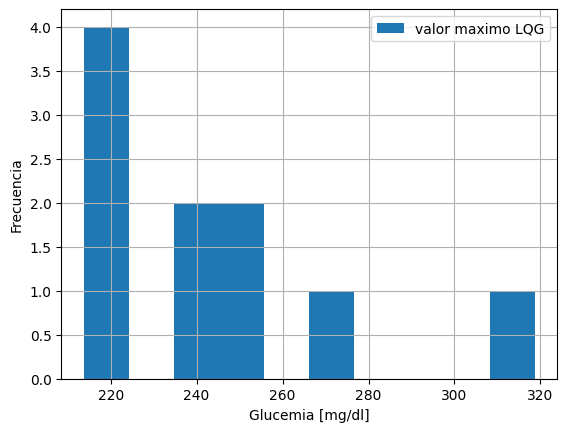

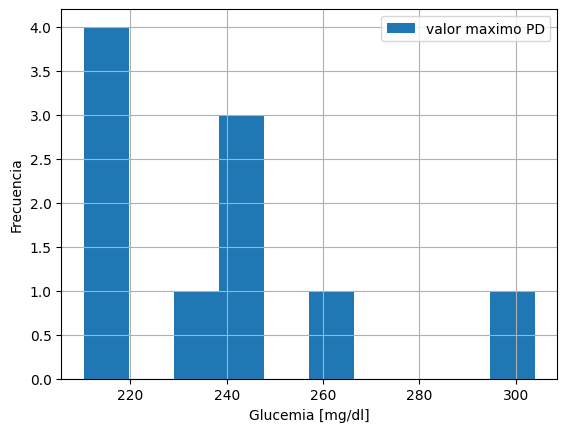

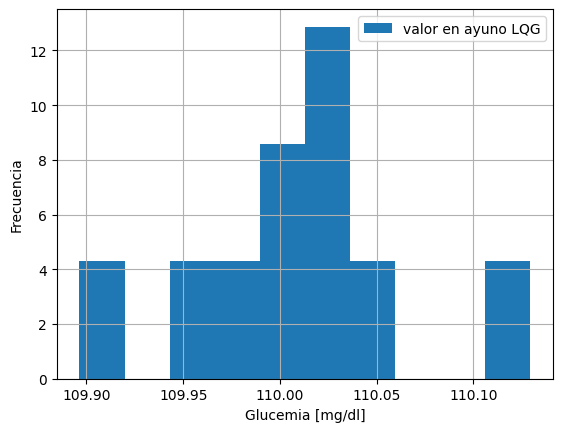

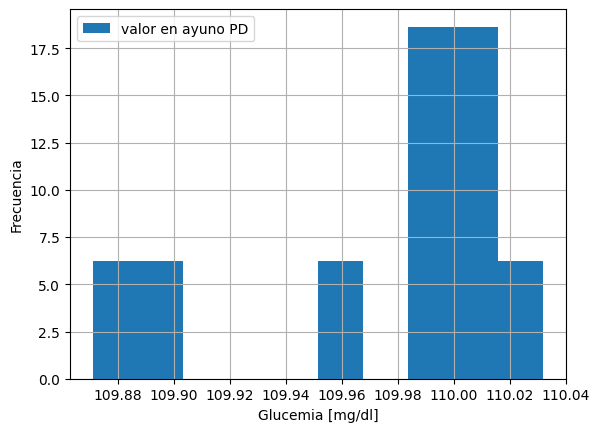

In [7]:
# Distribucion de los puntos de interes
#%matplotlib qt
%matplotlib inline
# Histograma del valor máximo de glucemia en cada grupo
plt.figure()
lqg_max.hist(label="valor maximo LQG")
plt.xlabel('Glucemia [mg/dl]')
plt.ylabel('Frecuencia')
plt.legend()
plt.figure()
pd_max.hist(label="valor maximo PD")
plt.xlabel('Glucemia [mg/dl]')
plt.ylabel('Frecuencia')
plt.legend()

# Test de normalidad de Shapiro-Wilk
estadistico_lqg_max, p_valor_lqg_max = ss.shapiro(lqg_max)
if p_valor_lqg_max<0.05:   
    print("Se rechaza la hipotesis nula de normalidad para el valor máximo del LQG, por lo tanto no se puede decir que los datos siguen una distribucion normal")
    print("Su p valor es:{:.2f}".format(p_valor_lqg_max))

stadistico_pd_max, p_valor_pd_max = ss.shapiro(pd_max)
if p_valor_pd_max<0.05:
    print("Se rechaza la hipotesis nula de normalidad para el valor máximo del PD, por lo tanto no se puede decir que los datos siguen una distribucion normal")
    print("Su p valor es:{:.2f}".format(p_valor_pd_max))

# Histograma de los valores de glucemia en ayuno
plt.figure()
lqg_ayuno.hist(label="valor en ayuno LQG", density=True)
plt.xlabel('Glucemia [mg/dl]')
plt.ylabel('Frecuencia')
plt.legend()
plt.figure()
pd_ayuno.hist(label="valor en ayuno PD", density=True)
plt.xlabel('Glucemia [mg/dl]')
plt.ylabel('Frecuencia')
plt.legend()

# Test de normalidad de Shapiro-Wilk
estadistico_lqg_ayuno, p_valor_lqg_ayuno = ss.shapiro(lqg_ayuno)
if p_valor_lqg_ayuno<0.05:   
    print("Se rechaza la hipotesis nula de normalidad para los valores en ayuno del LQG, por lo tanto no se puede decir que los datos siguen una distribucion normal")
    print("Su p valor es: {:.2f}".format(p_valor_lqg_ayuno))
stadistico_pd_ayuno, p_valor_pd_ayuno = ss.shapiro(pd_ayuno)
if p_valor_pd_ayuno<0.05:
    print("Se rechaza la hipotesis nula de normalidad para los valores en ayuno del PD, por lo tanto no se puede decir que los datos siguen una distribucion normal")
    print("Su p valor es:{:.2f}".format(p_valor_pd_ayuno))

El test de Shapiro-Wilk da como resultado que, en al menos uno de los grupos de cada parametro, no se puede afirmar que los datos siguen una distribución nomal. Además, se observa en el histograma de cada uno que efectivamente los valores que más se repiten se encuentran desplazados del centro. Por lo tanto se debe realizar una prueba no parametrica para comparar diferencias en los grupos.

Se realiza el test de Levene para evaluar si las distribuciones de varianzas es similar entre los grupos.
* Hipotesis nula (H0) : los datos tienen la misma distribucion de varianzas
* Hipotesis alternativa (H1) : los datos tienen una distribucion de varianzas distinta

In [8]:
#Si el valor p de la prueba de Levene es superior a 0,05, las varianzas no son significativamente diferentes entre 
#sí (es decir, se cumple el supuesto de homogeneidad de la varianza). 
#Si el valor p de la prueba de Levene es inferior a 0,05, entonces existe una diferencia significativa entre las varianzas. 
estadistico,p_valor =  ss.levene(lqg_max,pd_max)
if p_valor<0.05:
    print("Se rechaza la hipotesis nula. Existe una diferencia significativa entre la varianza de los grupos del valor máximo con p valor: {:.2f}".format(p_valor))
estadistico,p_valor = ss.levene(lqg_ayuno,pd_ayuno)
if p_valor<0.05:
    print("Se rechaza la hipotesis nula. Existe una diferencia significativa entre la varianza de los grupos del valor en ayuno con p valor: {:.2f}".format(p_valor))

No se rechaza la hipotesis nula del test de levene, por lo tanto las varianzas de los grupos son similares para ambos parámetros (valor máximo y en ayuno).

En resumen, se pueden mencionar las siguientes caracteristicas de los datos obtenidos:
*   Poseen varianzas semejantes entre grupos.
*   Las muestras son pareadas ya que son tomadas de una simulación y por lo tanto los tiempos de observación son iguales para cada grupo. 
*   No siguen una distribución normal.
*   Los mismos pertenecen a una variable continua.
*   Las muestras están relacionadas ya que pertenecen a la misma población pero con distintos tratamientos.
*   Las muestras son independientes.

Conociendo esta información, es posible utilizar el test de Wilcoxon para la comparación entre la estrategia original y la nueva. 

El test de Wilcoxon tiene las siguientes hipótesis:
* Hipótesis nula (H0): No hay diferencia significativa entre los dos grupos.
* Hipótesis alternativa (H1): Existe una diferencia significativa entre los dos grupos de la población.

In [9]:
# Test no parametrico de Wilcoxon
estadistico,p_valor = ss.wilcoxon(lqg_max,pd_max)
if p_valor<0.05:
    print("Se rechaza la hipotesis nula del test de Wilcoxon, existe una diferencia significativa en el valor máximo de glucemia.")
estadistico,p_valor = ss.wilcoxon(lqg_ayuno,pd_ayuno)
if p_valor<0.05:
    print("Se rechaza la hipotesis nula del test de Wilcoxon, existe una diferencia significativa en el valor de glucemia en ayuno.")

Se rechaza la hipotesis nula del test de Wilcoxon, existe una diferencia significativa en el valor máximo de glucemia.
Se rechaza la hipotesis nula del test de Wilcoxon, existe una diferencia significativa en el valor de glucemia en ayuno.


Para ambos parámetros se rechaza la hipótesis nula del test de Wilcoxon por lo que se concluye que existe una diferencia, tanto en el pico máximo de glucemia como en su valor en ayuno, entre la estrategia original y la nueva. En este caso, luego de realizar el test y observar la figura "Evolución temporal de glucosa en la población: Estrategia LQG y PD" se concluye que el pico de glucemia debido a la comida resulta significativamente menor con la nueva estrategia.

### Tabla de contigencia 



metodo  valores
False   False      7
        True       3
True    False      3
        True       7
Name: 300, dtype: int64
Power_divergenceResult(statistic=3.2, pvalue=0.36180502749753174)


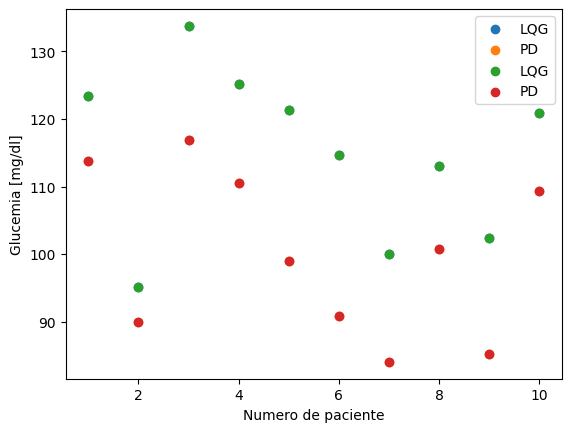

In [44]:
# Se define el umbral 
lim = 110
m   = 300
# Obtener los valores de glucemia de la muestra "m"
muestra_lqg = glcuemia_lqg.iloc[m]
muestra_pd  = glcuemia_pd.iloc[m]
p = np.linspace(1,10,10)
plt.scatter(p,muestra_lqg,label='LQG')
plt.scatter(p,muestra_pd,label='PD')
plt.legend()
plt.ylabel('Glucemia [mg/dl]')
plt.xlabel('Numero de paciente')

df2 = df.iloc[m]

muestras_totales = pd.concat([muestra_lqg, muestra_pd])
df1    = pd.DataFrame({'metodo':muestras_totales.index,'valores': muestras_totales})
A      = df1['metodo'].str.contains('lqg')
B      = df1['valores']>lim
# Se define el umbral 
lim = 110
m   = 300
# Obtener los valores de glucemia de la muestra "m"
muestra_lqg = glcuemia_lqg.iloc[m]
muestra_pd  = glcuemia_pd.iloc[m]
p = np.linspace(1,10,10)
plt.scatter(p,muestra_lqg,label='LQG')
plt.scatter(p,muestra_pd,label='PD')
plt.legend()
plt.ylabel('Glucemia [mg/dl]')
plt.xlabel('Numero de paciente')

df2 = df.iloc[m]

muestras_totales = pd.concat([muestra_lqg, muestra_pd])

# Esto es solo para que me ponga los nombres "metodo" y "valores" en la tabla de contingencia
df1    = pd.DataFrame({'metodo':muestras_totales.index,'valores': muestras_totales})
A      = df1['metodo'].str.contains('lqg')
B      = df1['valores']>lim

# Tabla y chi test
groups = muestras_totales.groupby([A,B]).count()
print(groups)
print(ss.chisquare(groups, ddof=0, axis=0))


### Regresión lineal
 
A continuación, se presentan datos para la misma población bajo estudio pero en escenarios con comidas de distinta
cantidad de carbohidratos. El objetivo es utilizar una recta de regresión para encontrar una relacioón entre la cantidad de carbohidratos de la comida y el valor medio del pico máximo de glucemia de la población con cada estrategia. 
A modo de aclaración, al momento de interpretar los resultados se debe tener en cuenta que este análisis es un primer acercamiento al comportamiento de la glucemia en esta población en particular y puede no ser representativo del caso general.

Promedio del valor máximo con 50 gCHO en el LQG: 201.15
Promedio del valor máximo con 50 gCHO en el PD: 198.91
Promedio del valor máximo con 60 gCHO en el LQG: 219.20
Promedio del valor máximo con 60 gCHO en el PD: 216.34
Promedio del valor máximo con 70 gCHO en el LQG: 243.44
Promedio del valor máximo con 70 gCHO en el PD: 237.45
Promedio del valor máximo con 80 gCHO en el LQG: 254.18
Promedio del valor máximo con 80 gCHO en el PD: 249.91
Promedio del valor máximo con 90 gCHO en el LQG: 272.28
Promedio del valor máximo con 90 gCHO en el PD: 267.39

Coeficiente de correlacion de Pearson para el LQG: 0.99 con p valor: 0.001
Coeficiente de correlacion de Pearson para el PD: 1.00 con p valor: 0.0002


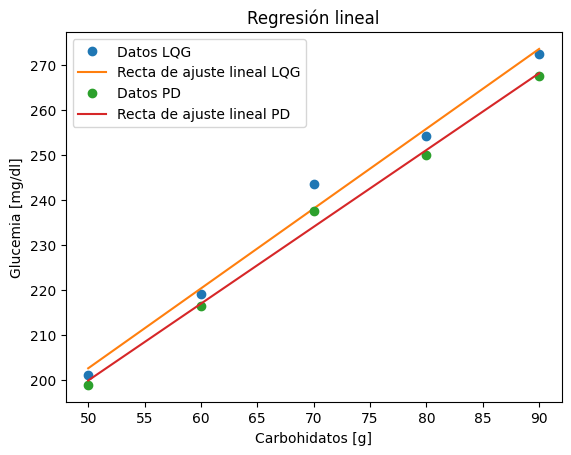

In [11]:
# Importación de los datos
# Lista de valores para reemplazar en el nombre del archivo
carbohidratos  = [50, 60, 70, 80, 90]
g_mean_max_lqg = np.zeros((1, 5))
g_mean_max_pd  = np.zeros((1, 5))

# Se extraen los datos de los valores máximos para cada comida y se calcula el valor medio en cada caso
for i, CHO in enumerate(carbohidratos):
    # Nombre del archivo con el valor actual
    file_name = f"tabla_glucosa_{CHO}gCHO.csv"
    # Lectura del archivo
    df2 = pd.read_csv(file_name)
    g_mean_max_lqg[0, i] = np.mean(df2.iloc[:,0:10].max())  # Promedio entre los 10 pacientes con el lqg para cada comida
    g_mean_max_pd[0, i]  = np.mean(df2.iloc[:,10:20].max())  # Promedio entre los 10 pacientes con el lqg para cada comida
    # Se imprimen los resultados
    print("Promedio del valor máximo con", CHO, "gCHO en el LQG: {:.2f}".format(g_mean_max_lqg[0, i]))
    print("Promedio del valor máximo con", CHO, "gCHO en el PD: {:.2f}".format(g_mean_max_pd[0, i]))

# Convertir las listas en arreglos de NumPy
cho   = np.array(carbohidratos)
y_lqg = g_mean_max_lqg[0]
y_pd  = g_mean_max_pd[0]

# vector para calcular y graficar la recta de ajuste
x = np.linspace(min(carbohidratos), max(carbohidratos), 100)

# Test de correlacion de Pearson
estadistico,p_valor = ss.pearsonr(cho, y_lqg)
print("\nCoeficiente de correlacion de Pearson para el LQG: {:.2f}".format(estadistico),"con p valor: {:.3f}".format(p_valor))

estadistico,p_valor = ss.pearsonr(cho, y_pd)
print("Coeficiente de correlacion de Pearson para el PD: {:.2f}".format(estadistico),"con p valor: {:.4f}".format(p_valor))

# Recta de regresión lineal
y_lqg     = y_lqg.reshape(-1,1)
y_pd      = y_pd.reshape(-1,1)
cho       = cho.reshape(-1,1)
model_lqg = LinearRegression()
model_pd  = LinearRegression()


model_lqg.fit(cho, y_lqg)
model_pd.fit(cho, y_pd)

recta_lqg = model_lqg.coef_[0][0]*x + model_lqg.intercept_[0]
recta_pd  = model_pd.coef_[0][0]*x + model_pd.intercept_[0]


plt.plot(cho,y_lqg,'o',label='Datos LQG')
plt.plot(x,recta_lqg,label='Recta de ajuste lineal LQG')
plt.plot(cho,y_pd,'o',label='Datos PD')
plt.plot(x,recta_pd,label='Recta de ajuste lineal PD')

plt.title('Regresión lineal')
plt.xlabel('Carbohidatos [g]')
plt.ylabel('Glucemia [mg/dl]')
plt.legend()

En el test de correlación de Pearson se obtiene una correlación de 0.99 y 1 para el LQG y el PD respectivamente, ambas con un nivel de significancia menor a 0.05. Por lo tanto, la relacion entre la media del valor máximo de glucemia de la población y el contenido de carbohidratos de la comida se ajusta a una recta como se ve en la figura.